**Problem Statement**

The genuineness of Information has become a long term issue influencing organizations and society, both for printed and computerized media. On interpersonal organizations, the compass and impacts of data spread happen at such a quick pace thus enhanced that mutilated, off base or bogus data procures an enormous potential to cause genuine effects, in practically no time, for many clients.

To provide a solution to this problem, Machine Learning comes in handy. With an historical data that contains information on fake and real news, Machine Learning can be used to classify articles as either fake or not using underlying patterns from the historical data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split


import re
from nltk.stem import WordNetLemmatizer


import nltk
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer as detokenize
from nltk.corpus import stopwords

from textblob import TextBlob

import datetime as dt
import warnings
import string

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

# stop_words = []
stop_words = list(set(stopwords.words('english')))
warnings.filterwarnings('ignore')
punctuation = string.punctuation

In [3]:
import flask

In [3]:
# reading in the fake and true news data
fake_data = pd.read_csv("../news-classifier-model/data/archive/Fake.csv")
true_data = pd.read_csv("../news-classifier-model/data/archive/True.csv")

In [4]:
fake_data["label"] = 0
true_data["label"] = 1

In [5]:
fake_data.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [6]:
true_data.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [7]:
frames = [fake_data, true_data]
  
data = pd.concat(frames)

In [8]:
data.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [9]:
data.drop(["subject", "date"], axis=1, inplace=True)

In [10]:
df = shuffle(data)
df.reset_index(inplace=True, drop=True)

In [11]:
df.head()

,title,text,label
0,Russian aerobatics team joins Serbian display ...,BELGRADE (Reuters) - Russia s elite aerobatic ...,1
1,Plane crash in Russia's far east kills six: re...,MOSCOW (Reuters) - Six people were killed when...,1
2,OPEN-BORDER LIBERALS Put Entire Nation On High...,Thank you Angela Merkel German security servic...,0
3,BREAKING: HILLARY CAMPAIGN Planned Fake “GRASS...,Wikileaks released another email showing how p...,0
4,WATCH: Rand Paul Accidentally Admits We Need ...,Republican Senator Rand Paul spoke with CNN s ...,0


In [81]:
df.to_json("src/data.json", orient="records")

In [12]:
df.isnull().sum()

title    0
text     0
label    0
dtype: int64

## Data PreProcessing

Extracting some features from the title and news content
The news title and content contains some information that may be important in understaing the pattern undelying in fake or real articles. some of the information that could be extracted includes the length of the title and article, the number of words, the number of part of speech in each article content, etc. Hence we will extract these features and use them in the future to provide a model

In [13]:
def text_process(df):
    """
    Extracts some text information from both news title and content
    
    Input: 
        df (dataframe like object): This is a data read in using pandas
    
    Output: 
        df (datafame like object): This is a preprocessed data with some new columns extracted from the
            article title and content
    """
    df["title_len"] = df['title'].apply(len)  # getting the length of the title including space
    df["text_len"] = df['text'].apply(len)  # getting the length of the title including space
    df['char_count'] = df['text'].apply(len)
    df['word_count'] = df['text'].apply(lambda x: len(x.split()))  # counting the words in text excluding spaces
    df['word_density'] = df['char_count'] / (df['word_count']+1)  # average length of word used in each text
    df['punctuation_count'] = df['text'].apply(lambda x: len("".join(_ for _ in x if _ in punctuation))) 
    df['title_word_count'] = df['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))  #total number of proper case (title) words in the content
    df['upper_case_word_count'] = df['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()])) # total number of upper count words in the content
    df['stopword_count'] = df['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.lower() in stop_words]))  # total number of stopwords in the content
    
    return df

In [14]:
df = text_process(df)

In [15]:
def count_part_of_speech(text, pos):
    """
    This methos checks if first word in sentence is a verb or not

    PARAMETERS 
        text (str): Text to be processed   
    RETURN
        Returns (bool): a boolean to confirm if first word in sentence is a verb or not
    """
    pos_dic = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
    }

    word_list = nltk.word_tokenize(text)
    count = 0
    pos_tags = nltk.pos_tag(word_list)  #obtaing the pos taggings
    for tag in pos_tags:
        
        #selecting the pos tag of the first item in the sentence
        _, first_tag = tag

        #checking if the first word in the senntece has a pos tagging of VERB
        if first_tag in pos_dic[pos]:
            count += 1
    return count

In [31]:
def reduce_text(text, num_sent = 4):
    """
    This function reduces the volume of the text content by selecting a number of sentence.
    
    Input:
        text (str): the text content which we want to reduce
        num_sent (int): the number of sentence we may want to select
        
    Output:
        text (str): a sample of the text that is be selected
    """
    content = ""
    try:
        tokenized_sentence = sent_tokenize(text)
        reduced_tokenized_sentence = tokenized_sentence[:num_sent]
        content = detokenize().detokenize(reduced_tokenized_sentence)
    except:
        pass
    # content = detokenize().detokenize(sent_tokenize(text)[:num_sent])
    return content

In [32]:
df['reduced_text'] = df['text'].apply(lambda text: reduce_text(text))

In [35]:
def extract_part_of_speech(df):
    """
    This function extracts some part of speech and saves their counts in a columns
    
    Input:
        df (dataframe): The dataframe object
    
    Output:
        df (dataframe): The extended dataframe with the new columns
    """
    
    df['noun_count'] = df['reduced_text'].apply(lambda x: count_part_of_speech(x, 'noun'))
    df['verb_count'] = df['reduced_text'].apply(lambda x: count_part_of_speech(x, 'verb'))
    df['adj_count'] = df['reduced_text'].apply(lambda x: count_part_of_speech(x, 'adj'))
    df['adv_count'] = df['reduced_text'].apply(lambda x: count_part_of_speech(x, 'adv'))
    df['pron_count'] = df['reduced_text'].apply(lambda x: count_part_of_speech(x, 'pron'))
    
    return df

In [37]:
df = extract_part_of_speech(df)

In [38]:
# dropping unused colums

df.drop(['char_count'], axis=1, inplace=True)

# Data Exploration and Visualization


Exploring and visualizing features is one important process of data science. it helps us to examine how the features are distributed.

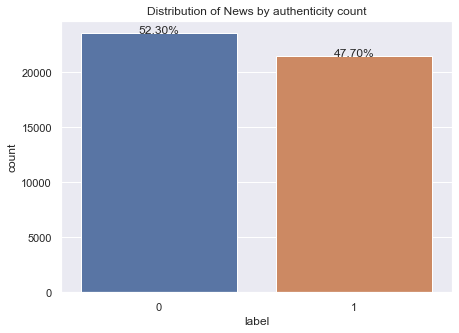

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
ax = sns.countplot(x='label', data=df, ax = axes,);
plt.title("Distribution of News by authenticity count")

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/float(len(df))*100)+'%',
            ha="center")

## What is the relationship of the word counts and upper case count in the news content

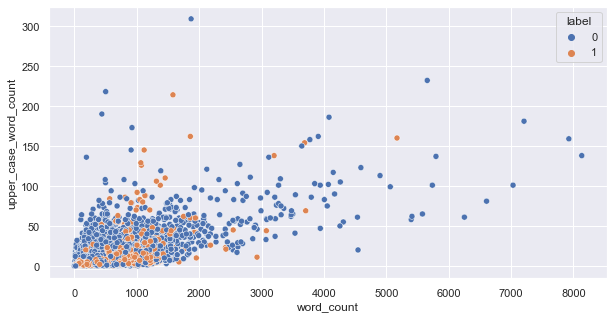

In [40]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
sns.scatterplot(x='word_count', y='upper_case_word_count', data=df, hue='label');

## What is the correlation of punctuation counts and title case count in the text content

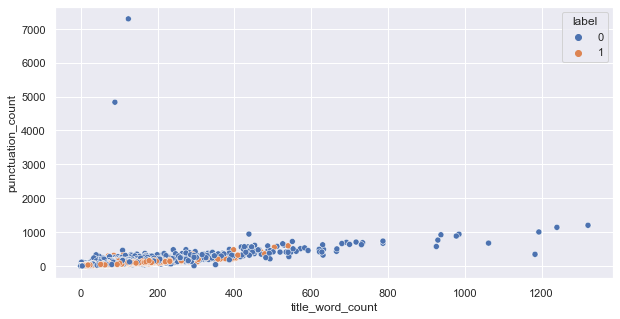

In [41]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
sns.scatterplot(x='title_word_count', y='punctuation_count', data=df, hue='label', );

## what is the relationship of the word counts and stopword count in the text content.

<AxesSubplot:xlabel='stopword_count', ylabel='word_count'>

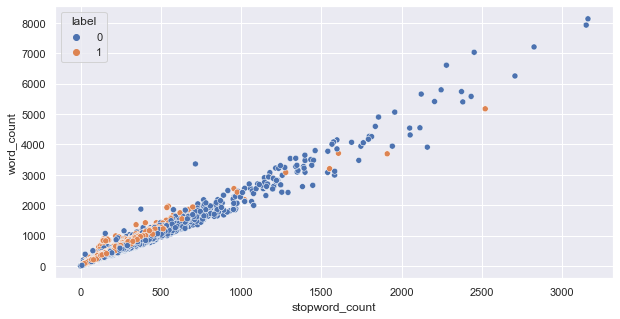

In [42]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
sns.scatterplot(x='stopword_count', y='word_count', data=df, hue='label')

## What is the relationship of the numeric features

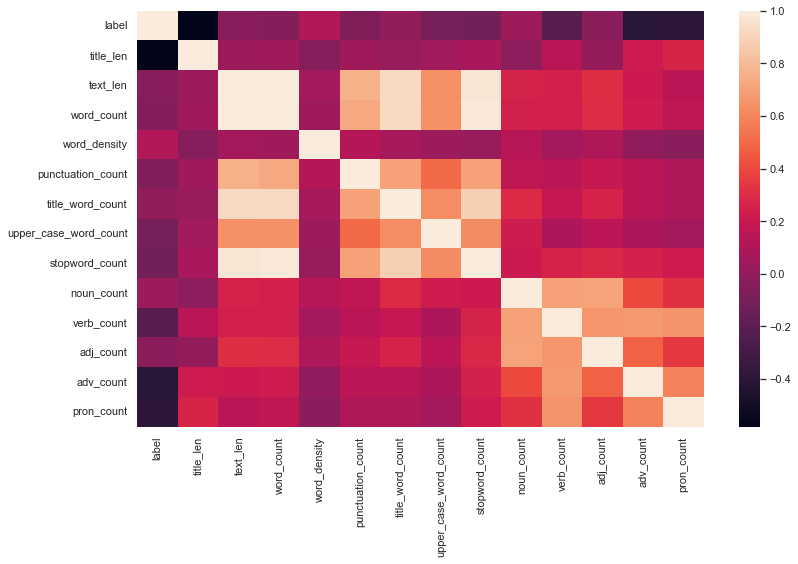

In [43]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr())
plt.tight_layout()

# building a model for the textual features

In [44]:
def tokenize(text):
    '''
    PARAMETERS 
        text (str): Text to be processed   
    RETURN
        Returns a processed text variable that was tokenized, lower cased, stripped, and lemmatized
    '''
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens

In [45]:
# selecting the target feature
y = df['label']

In [46]:
models = [('lr', LogisticRegression()), ('knn', KNeighborsClassifier()), ('cart', DecisionTreeClassifier()), ('svm', LinearSVC())]

In [59]:
def build_nlp_model(X, y, model):
    """
    This function build trains a model using NLP pipeline
    
    Input:
        X (matrix, dataframe): This is the feature(s) which we want to use to fit a model
        Y (series): This is the target feature that we want to predict
    
    Output:
        y_test (series): a subset of the target variable that will be used to evaluate the model
        y_pred (series): the predicted y using the trained model
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)
    vect = CountVectorizer(tokenizer=tokenize)
    tfidf = TfidfTransformer()
    clf = model

    # train classifier
    X_train_counts = vect.fit_transform(X_train)
    X_train_tfidf = tfidf.fit_transform(X_train_counts)
    clf.fit(X_train_tfidf, y_train)

    # predict on test data
    X_test_counts = vect.transform(X_test)
    X_test_tfidf = tfidf.transform(X_test_counts)
    y_test_pred = clf.predict(X_test_tfidf)
    y_train_pred = clf.predict(X_train_tfidf)
    
    return y_train, y_train_pred, y_test, y_test_pred

# Model Evaluation and Validation
In order to evaluate the accuracy of the model, model accuracy score from the sklearn package was used. The evaluation metrics was used to choose which learning model classifier best fit the data.

In [56]:
def evaluate_model(model_names, accuracy_list, f1scores):
    """
    This function plots a line graph with two lines indicating the accuracy and recall of the model
    """
    # create figure and axis objects with subplots()
    fig, ax = plt.subplots(figsize=(12,8))
    # make a plot
    ax.plot(model_names, f1scores, color="red", marker="o")
    # set x-axis label
    ax.set_xlabel("Model",fontsize=14)
    # set y-axis label
    ax.set_ylabel("Model F1Score",color="red",fontsize=14)
    plt.ylim((0.0, 1.5))

    # twin object for two different y-axis on the sample plot
    ax2=ax.twinx()
    # make a plot with different y-axis using second axis object
    ax2.plot(model_names, accuracy_list,color="blue",marker="o")
    ax2.set_ylabel("Model Accuracy",color="blue",fontsize=14)
    plt.ylim((0.0, 1.5))

In [82]:
def evaluate_model(model_names, accuracy_dict, f1scores_dict):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,8))
    fig.suptitle('Sharing x per column, y per row')
    ax1.plot(model_names, accuracy_dict["train"])
    ax1.set_title("accuracy comparison of train data")
    ax2.plot(model_names, f1scores_dict["train"], 'tab:orange')
    ax2.set_title("f1scores comparison of train data")
    ax3.plot(model_names, accuracy_dict["test"], 'tab:green')
    ax3.set_title("accuracy comparison of test data")
    ax4.plot(model_names, f1scores_dict["test"], 'tab:red')
    ax4.set_title("f1scores comparison of train data")

    for ax in fig.get_axes():
        ax.label_outer()

In [83]:
def train_model (X, y, models, clf):
        
    """
    This function trains various and evaluates them to observe the best model
    
    Input:
        X (matrix, dataframe): the input features
        y (series): the target feature
        models: a dictionary of models that will be trained
    
    """
    accuracy = {
        "train": {},
        "test": {}
    }
    f1score = {
        "train": {},
        "test": {}
    }
    for i in range(len(models)):
        model = models[i]

        y_train, y_train_pred, y_test_text, y_pred_text = clf(X, y, model[1])
        accuracy["train"][model[0]] = accuracy_score(y_train, y_train_pred)
        accuracy["test"][model[0]] = accuracy_score(y_test_text, y_pred_text)
        f1score["train"][model[0]] = f1_score(y_train, y_train_pred)
        f1score["test"][model[0]] = f1_score(y_test_text, y_pred_text)
    
    model_names = list(f1score["train"].keys())
    f1scores_train = list(f1score["train"].values())
    f1scores_test = list(f1score["test"].values())
    accuracy_train = list(accuracy["train"].values())
    accuracy_test = list(accuracy["test"].values())
    accuracy_dict = {
        "train": accuracy_train,
        "test": accuracy_test
    }
    f1scores_dict = {
        "train": f1scores_train,
        "test": f1scores_test
    }
    evaluate_model(model_names, accuracy_dict, f1scores_dict)

## Using the reduced text to train a model

The first set of models to be trained would be trained using the reduce version of the news content. The following model including (logistic regression, k nearest neighbour, Decision tree classifier and Support vector classifier)

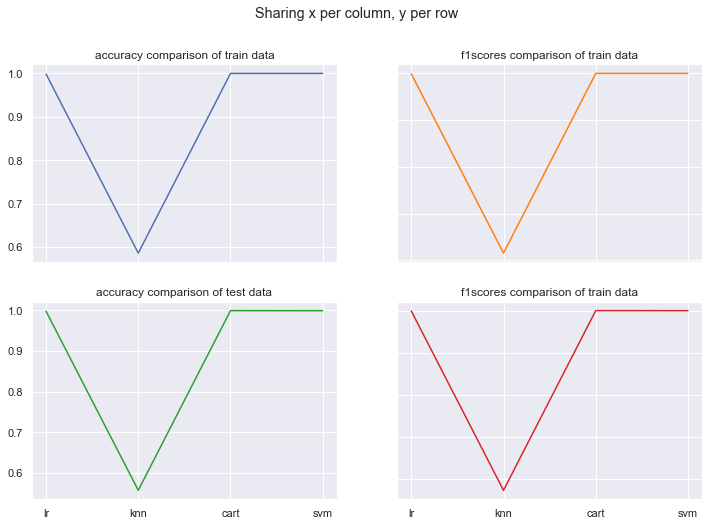

In [84]:
X_text = df['reduced_text']
train_model(X_text, y, models, build_nlp_model)

The plot above evaluates the trained models using our reduced news content. The models that were traines includes; logistic regression, k nearest neighbour, Decision tree classifier and Support vector classifier. As seen in the plot above, Logistic regression, Decision Tree and Support Vector Classifier all fit perectly well to the data with an Accuracy score of 1.0 for the three model. Looking at the performance of the model on the test data, it could be seen that the model performed exactly the same as it did with the training data. Since the train and test F1-score are the same, we may conclude that there is no overfitting when we used logistic regression, k nearest neighbour, Decision tree classifier and Support vector classifier to train our models

## Using the title to train a model


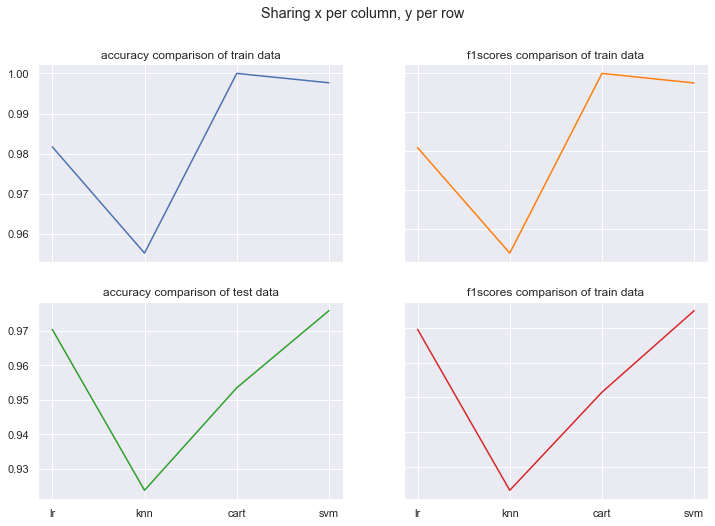

In [85]:
X_title = df['title']
train_model(X_title, y, models, build_nlp_model)

## Using the full text to train the model

In [ ]:
X_title = df['text']
train_model(X_title, y, models, build_nlp_model)

In [ ]:
def build_model(X, y, model):
    """
    This function build trains a model using extracted features
    
    Input:
        X (matrix, dataframe): This is the feature(s) which we want to use to fit a model
        Y (series): This is the target feature that we want to predict
    
    Output:
        y_test (series): a subset of the target variable that will be used to evaluate the model
        y_pred (series): the predicted y using the trained model
    """
    
    scaler = StandardScaler()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)
    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    model = model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return y_test, y_pred

In [ ]:
X = df.drop(['title', 'label', 'reduced_text', 'text'], axis=1)

In [ ]:
train_model(X, y, models, build_model)